### Import packages and set working directory

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import random

In [2]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots'
my_data_dir = proj_dir + '/my_data'
nb_dir = proj_dir + '/notebooks'

In [3]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [4]:
from letkf import *
from post_processing_fns import *

In [5]:
random.seed(652549)

### Load data

In [6]:
## Load covariance matrices

# South Pacific
sp_cov = np.load(my_data_dir +'/south_pacific_cov.npy')
sp_cov_ocn = sp_cov[64:, 64:]
sp_cov_atm = sp_cov[:64, :64]

# Southern Ocean
so_cov = np.load(my_data_dir +'/southern_ocean_cov.npy')
so_cov_ocn = so_cov[64:, 64:]
so_cov_atm = so_cov[:64, :64]

# Indian Ocean
io_cov = np.load(my_data_dir +'/indian_ocean_cov.npy')
io_cov_ocn = io_cov[64:, 64:]
io_cov_atm = io_cov[:64, :64]

In [7]:
## Get state positions
ocn_z = np.load(my_data_dir+'/ocn_z.npy')
atm_p = np.load(my_data_dir+'/atm_p.npy')/1e2
atm_log_p = np.log(atm_p)

### Define parameters

In [9]:
# ocn indices associated with depth
ind150m = 37
ind500m = 50
ind2km = 67
# atm indices associated with pressure
ind100hPa = 23
# ast and sst indices in coupled column
ind_ast = 63
ind_sst = 64

In [19]:
# Define a range of localization radii for ocn and atm
loc_rads_ocn = [5, 15, 30, 40, 50, 60, 70, 80, 100, 200]
loc_rads_atm = [1, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.2, 2.4, 2.6]
loc_rads_crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 1.5, 2]

In [8]:
this_cov_ocn = io_cov_ocn
this_cov_sqrt_ocn = np.linalg.cholesky(this_cov_ocn)
this_cov_atm = io_cov_atm
this_cov_sqrt_atm = np.linalg.cholesky(this_cov_atm)
this_short_name = 'io'
this_full_name = 'Indian Ocean'

### Find optimal localization radii within a single domain

In [11]:
# Find optimal localization radius for assimilation of SST into ocn
errs_ocn = run_multiple_trials_one_domain(observe_this_level=0, localization_radii=loc_rads_ocn, this_cov=this_cov_ocn, this_cov_sqrt=this_cov_sqrt_ocn, pos_state=ocn_z, stop=ind2km)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


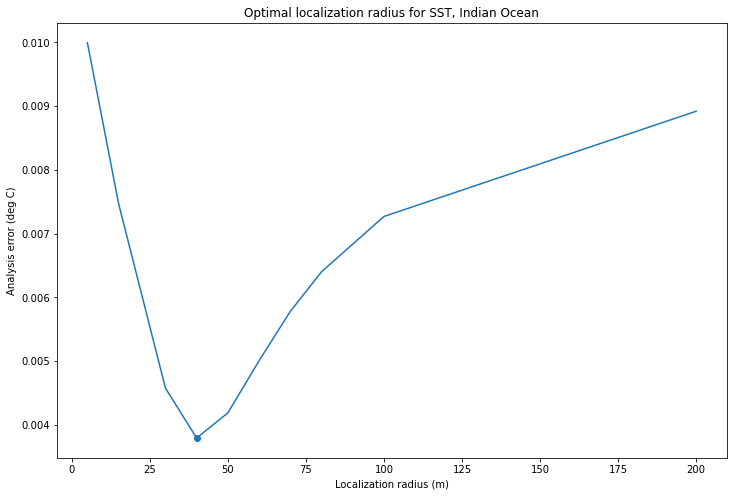

In [13]:
# Plot
plt.plot(loc_rads_ocn, errs_ocn)
min_ind = np.argmin(errs_ocn)
plt.plot(loc_rads_ocn[min_ind], errs_ocn[min_ind], 'o', color='tab:blue')

# Labels
plt.xlabel('Localization radius (m)')
plt.ylabel('Analysis error (deg C)')
plt.title('Optimal localization radius for SST, '+this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
#plt.savefig(plot_dir+'/opt_loc_rad_sst_ocn_'+this_short_name)
plt.show()

In [14]:
# Find optimal localization radius for assimilation of AST into atm
errs_atm = run_multiple_trials_one_domain(observe_this_level=-1, localization_radii=loc_rads_atm, this_cov=this_cov_atm, this_cov_sqrt=this_cov_sqrt_atm, pos_state=atm_log_p, start = ind100hPa, stop=-1)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


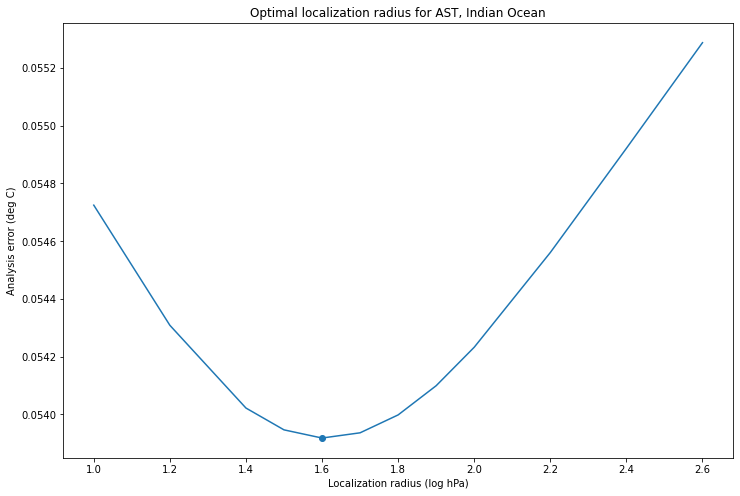

In [15]:
# Plot
plt.plot(loc_rads_atm, errs_atm)
min_ind = np.argmin(errs_atm)
plt.plot(loc_rads_atm[min_ind], errs_atm[min_ind], 'o', color='tab:blue')

# Labels
plt.xlabel('Localization radius (log hPa)')
plt.ylabel('Analysis error (deg C)')
plt.title('Optimal localization radius for AST, '+this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
#plt.savefig(plot_dir+'/opt_loc_rad_ast_atm_'+this_short_name)
plt.show()

### Find optimal localization radii across domains

In [21]:
def compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, start=0, stop=37):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_cov_sqrt @ np.random.normal(size=(num_levs, 1)) # change to analysis cov sqrt
    y_ob = HofX @ this_cov_sqrt @ np.random.normal(xt, scale=1, size=xt.shape) # obs error set to equal background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_ens)
    bg_error = np.sqrt(np.mean(np.diag(P_ens)))

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate analysis increments
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    perfect_innovation = y_ob - HofX @ xt
    kalman_gain = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    kf_increment = kalman_gain * perfect_innovation 
    
    ## Take only state
    x_ens = x_ens[ind_state]
    background_mean = background_mean[ind_state]
    kf_increment = kf_increment[ind_state]
    num_levs = len(ind_state)
    
    ## Get analysis mean
    num_loc_rads =  len(loc_rads_state)
    analysis_error = np.empty(num_loc_rads)
    background_error = np.empty(num_loc_rads)
    da_increment = np.empty((num_levs, num_loc_rads))
    for loc_ind in range(num_loc_rads):
        # Set localization radius
        localization_radius = loc_rads_state[loc_ind]
        loc_rad_state = np.full_like(pos_state, localization_radius)
        # Get analysis mean
        analysis_mean = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1)[0]
        this_increment = analysis_mean - background_mean
        da_increment[:, loc_ind] = this_increment
        # Get analysis error
        analysis_error[loc_ind] = np.sqrt( np.mean( np.square( this_increment[start:stop] - kf_increment[start:stop,0]) ) )
        background_error[loc_ind] = bg_error
    
    return analysis_error, da_increment, kf_increment, innovation, background_error

In [22]:
def run_multiple_trials(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, start=0, stop=-1, num_trials=100):
    errs = np.empty((len(loc_rads_state), num_trials))
    for trial in range(num_trials):
        analysis_error = compute_analysis(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, start=start, stop=stop)[0]
        errs[:, trial] = analysis_error
    avg_err = np.mean(errs, axis=1)
    return avg_err

In [32]:
## Observe sst and assimilate into atm
ind_state = np.arange(0, 64)
ind_ob = ind_sst
loc_rad_ob = 40
this_cov = io_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
pos_state = np.abs(atm_log_p - atm_log_p[-1])
pos_ob = ocn_z[0]
loc_rads_state = loc_rads_crs

In [33]:
analysis_error, da_increment, kf_increment, innovation, backgroound_error = compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, start = ind100hPa, stop=-1)
kg_sst = kf_increment/innovation

In [26]:
# Find optimal localization radius for assimilation of AST into atm
errs_crs = run_multiple_trials(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, start=ind100hPa, num_trials=1000)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


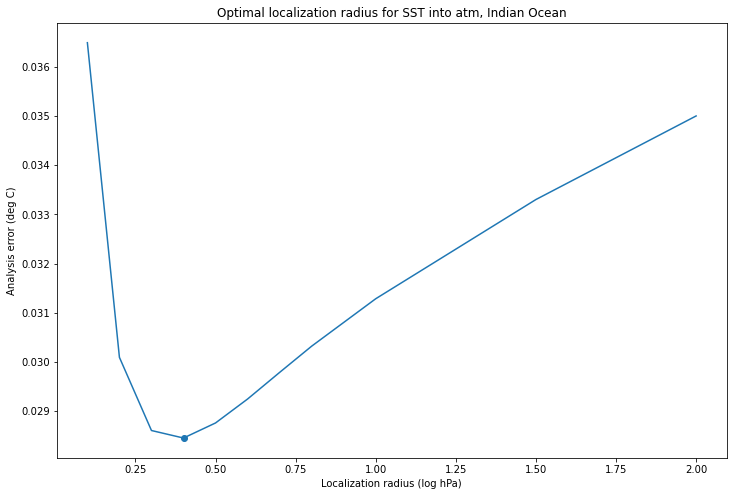

In [27]:
# Plot
plt.plot(loc_rads_crs, errs_crs)
min_ind = np.argmin(errs_crs)
plt.plot(loc_rads_crs[min_ind], errs_crs[min_ind], 'o', color='tab:blue')

# Labels
plt.xlabel('Localization radius (log hPa)')
plt.ylabel('Analysis error (deg C)')
plt.title('Optimal localization radius for SST into atm, '+this_full_name)

# Save and show
plt.rcParams['figure.figsize'] = [12,8]
#plt.savefig(plot_dir+'/opt_loc_rad_sst_atm_'+this_short_name)
plt.show()

### Look at Kalman gains

In [ ]:
## Observe sst and assimilate into atm
ind_state = np.arange(0, 64)
ind_ob = ind_sst
loc_rad_ob = 40
this_cov = io_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
pos_state = np.abs(atm_log_p - atm_log_p[-1])
pos_ob = ocn_z[0]
loc_rads_state = loc_rads_crs[np.argmin(errs_crs)]

In [ ]:
analysis_error, da_increment, kf_increment, innovation, backgroound_error = compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, start = ind100hPa, stop=-1)
kg_sst = kf_increment/innovation

In [35]:
## Plot kalman gain for assimilation of ast into atm
ind_state = np.arange(0, 64)
ind_ob = ind_ast
loc_rad_ob = 1.7
this_cov = io_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
pos_state = np.abs(atm_log_p - atm_log_p[-1])
pos_ob = pos_state[-1]
loc_rads_state = [1.7]

In [36]:
analysis_error, da_increment, kf_increment, innovation, background_error = compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, start = 0, stop=-1)
kg_ast = kf_increment/innovation

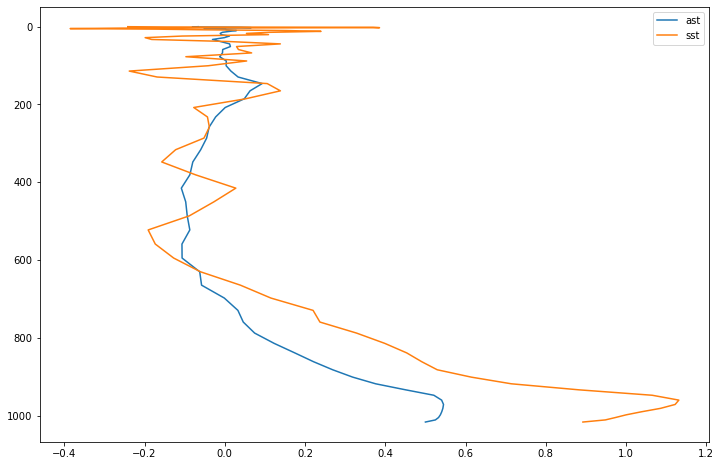

In [37]:
ax = plt.axes()
plt.plot(kf_ast, atm_p, label='ast')
plt.plot(kf_sst, atm_p, label='sst')
#plt.plot(da_increment, atm_p)
#plt.plot(innovation, atm_p[63], 'o')
plt.legend()

ax.invert_yaxis()
plt.show()

In [82]:
da_gains_ast = np.zeros((64,1000))
for trial in range(1000):
    analysis_error, da_increment, kf_increment, innovation, background_error = compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, start = 0, stop=-1)
    da_gains_ast[:, trial] = da_increment[:,0]/innovation

In [83]:
da_gain_mean_ast = np.mean(da_gains_ast, axis=1)
da_gain_05_ast = np.percentile(da_gains_ast, 5, axis=1)
da_gain_95_ast = np.percentile(da_gains_ast, 95, axis=1)
da_gain_25_ast = np.percentile(da_gains_ast, 25, axis=1)
da_gain_75_ast = np.percentile(da_gains_ast, 75, axis=1)

In [85]:
background_error_sd =  np.sqrt(np.diag(this_cov))

In [92]:
background_error_sd[:64]

array([0.39915193, 0.77902664, 0.53102449, 0.78796077, 0.59912627,
       0.73190574, 0.64537809, 0.6108023 , 0.56250926, 0.62330787,
       0.58490021, 0.51773682, 0.47082782, 0.48276808, 0.45760073,
       0.44848779, 0.42604963, 0.40214648, 0.42298206, 0.38127402,
       0.38712068, 0.3824172 , 0.43661013, 0.44699325, 0.39805765,
       0.45163609, 0.52259771, 0.53697247, 0.53649228, 0.39857772,
       0.37276997, 0.34980713, 0.36309717, 0.37146166, 0.39024558,
       0.43683886, 0.49247516, 0.43607172, 0.43324017, 0.47816441,
       0.40445422, 0.40614614, 0.39487739, 0.38517399, 0.37768761,
       0.36971334, 0.35060625, 0.36029713, 0.39350616, 0.43810735,
       0.46068655, 0.46370882, 0.48658383, 0.56125176, 0.60032604,
       0.60808769, 0.60501764, 0.59518301, 0.58015366, 0.56655163,
       0.55568973, 0.54710458, 0.53724405, 0.51013973])

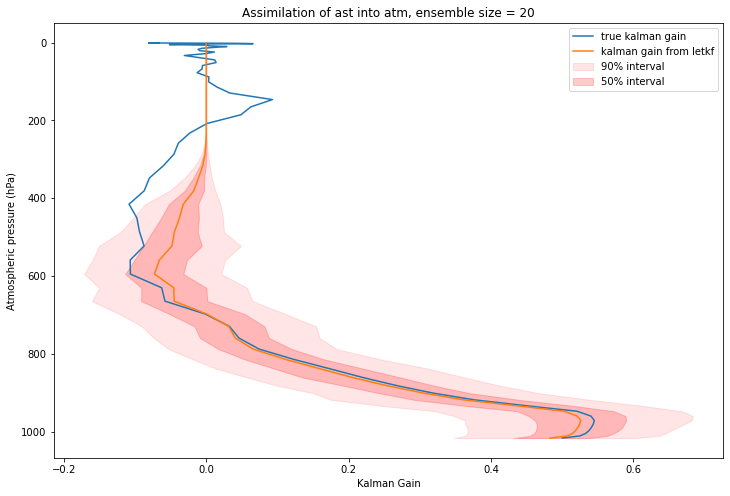

In [94]:
ax = plt.axes()
plt.plot(kalman_gain_ast, atm_p, label='true kalman gain')
plt.plot(da_gain_mean_ast, atm_p, label='kalman gain from letkf')
ax.fill_betweenx(atm_p, da_gain_05_ast, da_gain_95_ast, color='r', alpha=.1, label='90% interval')
ax.fill_betweenx(atm_p, da_gain_25_ast, da_gain_75_ast, color='r', alpha=.2, label='50% interval')
plt.legend()
plt.xlabel('Kalman Gain')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Assimilation of ast into atm, ensemble size = '+str(ens_size))

ax.invert_yaxis()
plt.rcParams['figure.figsize'] = [12,8]
#plt.savefig(plot_dir+'/atm_ast_ci_ens_size_'+str(ens_size))
plt.show()

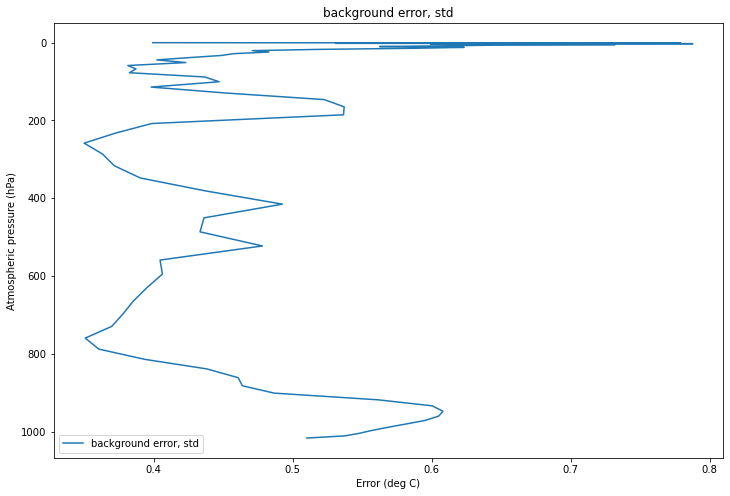

In [100]:
ax=plt.axes()
plt.plot(background_error_sd[:64], atm_p, label='background error, std')

plt.title('background error, std')
ax.invert_yaxis()
ax.legend()
plt.xlabel('Error (deg C)')
plt.ylabel('Atmospheric pressure (hPa)')

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_background_error'+str(ens_size))
plt.show()

In [38]:
## Plot kalman gain for assimilation of sst into atm
## Observe sst
ind_state = np.arange(0, 64)
ind_ob = 64
loc_rad_ob = 40
this_cov = io_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
pos_state = np.abs(atm_log_p - atm_log_p[-1])
pos_ob = ocn_z[0]
loc_rads_state = [.8]

In [40]:
analysis_error, da_increment, kf_increment, innovation, backgorund_error = compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, start = 0, stop=-1)
kalman_gain_sst = kf_increment/innovation

In [41]:
da_gains_sst = np.zeros((64,1000))
for trial in range(1000):
    analysis_error, da_increment, kf_increment, innovation = compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_cov, this_cov_sqrt, pos_state, pos_ob, start = 0, stop=-1)
    da_gains_sst[:, trial] = da_increment[:,0]/innovation

ValueError: too many values to unpack (expected 4)

In [42]:
da_gain_mean_sst = np.mean(da_gains_sst, axis=1)
da_gain_05_sst = np.percentile(da_gains_sst, 5, axis=1)
da_gain_95_sst = np.percentile(da_gains_sst, 95, axis=1)
da_gain_25_sst = np.percentile(da_gains_sst, 25, axis=1)
da_gain_75_sst = np.percentile(da_gains_sst, 75, axis=1)

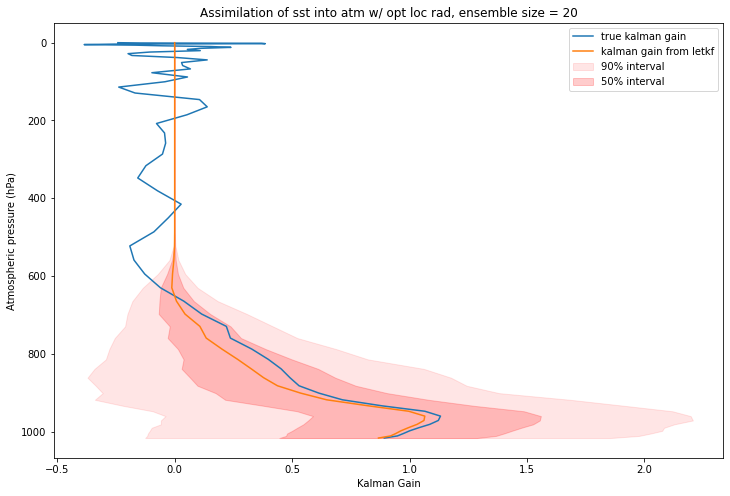

In [43]:
ax = plt.axes()
plt.plot(kg_sst, atm_p, label='true kalman gain')
plt.plot(da_gain_mean_sst, atm_p, label='kalman gain from letkf')
ax.fill_betweenx(atm_p, da_gain_05_sst, da_gain_95_sst, color='r', alpha=.1, label='90% interval')
ax.fill_betweenx(atm_p, da_gain_25_sst, da_gain_75_sst, color='r', alpha=.2, label='50% interval')
plt.legend()
plt.xlabel('Kalman Gain')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Assimilation of sst into atm w/ opt loc rad, ensemble size = '+str(ens_size))

ax.invert_yaxis()
plt.rcParams['figure.figsize'] = [12,8]
#plt.savefig(plot_dir+'/atm_sst_ci_opt_loc_ens_size_'+str(ens_size))
plt.show()

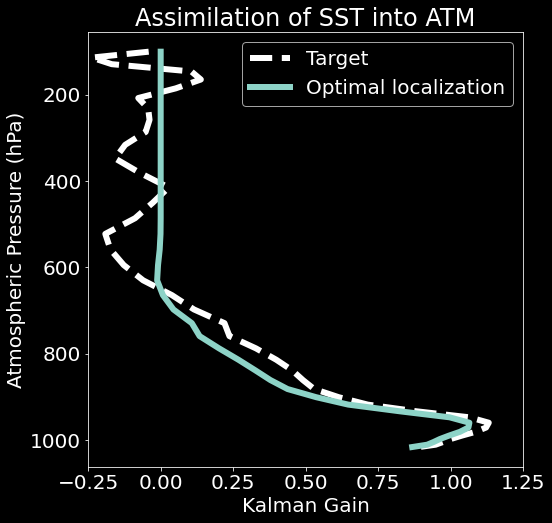

In [72]:
#plt.style.use('dark_background')
ax = plt.axes()
plt.plot(kalman_gain_sst[23:], atm_p[23:], 'w--', label='Target', linewidth=6)
plt.plot(da_gain_mean_sst[23:], atm_p[23:], label='Optimal localization', linewidth=6)
#ax.fill_betweenx(atm_p, da_gain_05_sst, da_gain_95_sst, color='r', alpha=.1, label='90% interval')
#ax.fill_betweenx(atm_p, da_gain_25_sst, da_gain_75_sst, color='r', alpha=.2, label='50% interval')
plt.legend(loc='upper right')
plt.xlabel('Kalman Gain')
plt.ylabel('Atmospheric Pressure (hPa)')
plt.title('Assimilation of SST into ATM')

ax.invert_yaxis()
ax.set_xlim([-.25, 1.25])
ax.set_box_aspect(1)
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['font.size'] = '20'
plt.savefig(plot_dir+'/psl_seminar_atm_sst_ci_opt_loc_ens_size_'+str(ens_size))
plt.show()

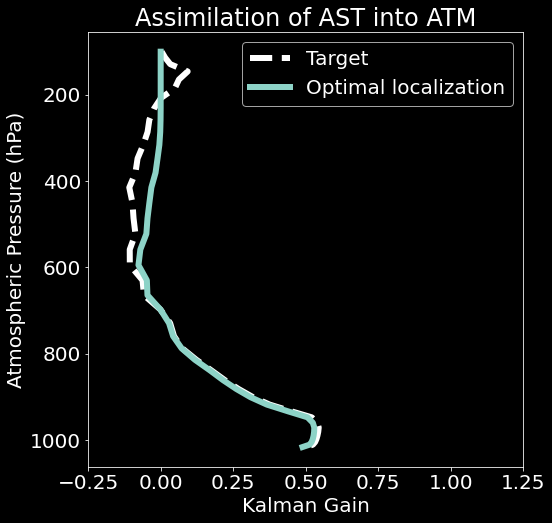

In [74]:
ax = plt.axes()
plt.plot(kalman_gain_ast[23:], atm_p[23:], 'w--', label='Target', linewidth=6)
plt.plot(da_gain_mean_ast[23:], atm_p[23:], label='Optimal localization', linewidth=6)
plt.legend()
plt.xlabel('Kalman Gain')
plt.ylabel('Atmospheric Pressure (hPa)')
plt.title('Assimilation of AST into ATM')

ax.invert_yaxis()
ax.set_xlim([-.25, 1.25])
ax.set_box_aspect(1)
plt.rcParams['figure.figsize'] = [12,8]
#plt.savefig(plot_dir+'/psl_seminar_atm_ast_ci_ens_size_'+str(ens_size))
plt.show()

In [28]:
this_cov = io_cov

In [43]:
io_cor = np.load(my_data_dir +'/indian_ocean_cor.npy')
this_cor = io_cor

In [19]:
ind_ast = 63
kg_ast = (this_cov[ind_ast,:]/(2*this_cov[ind_ast,ind_ast]))

In [21]:
ind_sst = 64
kg_sst = (this_cov[ind_sst,:]/(2*this_cov[ind_sst,ind_sst]))

In [41]:
sigma2_ast = this_cov[ind_ast, ind_ast]
sigma2_sst = this_cov[ind_sst, ind_sst]

sigma_ast = np.sqrt(sigma2_ast)
sigma_sst = np.sqrt(sigma2_sst)

In [44]:
cor_ast_sst = this_cor[ind_ast, ind_sst]

In [49]:
0.5 * (sigma_ast/sigma_sst) * cor_ast_sst

0.8924648896278365

In [50]:
kg_sst[ind_ast]

0.8924648896278364

In [52]:
kg_sst[60:65]

array([1.00028515, 0.97350877, 0.9483013 , 0.89246489, 0.5       ])

In [53]:
this_cor[ind_sst, 60:65]

array([0.33633469, 0.33246791, 0.32980326, 0.32687538, 1.        ])

In [55]:
np.sqrt(this_cov[ind_sst, 60:65])

array([0.13213782, 0.13035724, 0.12865847, 0.12481328, 0.09342223])

In [56]:
sigma_ast

0.5101397344784931

In [57]:
sigma_sst

0.09342222837766732